In [1]:
### we will be analyzing 

# NEP Training Dataset Diagnostics

This notebook analyzes NEP extended XYZ training datasets.

Features:
- Energy per-atom histograms
- Force magnitude histograms
- Per-file distributions
- Global distributions
- Configurable limits (energy / force)
- Consistent axis scaling for comparison

Designed for:
- NEP / MLIP sanity checks
- Dataset imbalance detection
- Outlier identification



In [2]:
from pathlib import Path

# ============================================================
# DATA LOCATION
# ============================================================

#XYZ_DIR = Path("/blue/ypchen/emir.bilgili/NEP-TEST/proj/data/xyz/with_energy_offset")


XYZ_DIR = Path("/blue/ypchen/emir.bilgili/NEP-TEST/proj/data/xyz/all_data_10-20")
XYZ_FILES = sorted(XYZ_DIR.glob("*.xyz"))

# ============================================================
# HISTOGRAM CONTROLS
# ============================================================

# Energy per atom (eV)
ENERGY_MIN  = -12
ENERGY_MAX  =  1.5 
ENERGY_BINS = 200

# Force magnitude (eV/Å)
FORCE_MIN  = 0.0
FORCE_MAX  = 30
FORCE_BINS = 200

# Range handling:
#   "filter" → discard values outside range
#   "clip"   → clamp values to min/max
RANGE_MODE = "clip"

# ============================================================
# PLOTTING CONTROLS
# ============================================================

SAVE_FIGURES = False
FIG_DPI = 200

# Log-scale options
LOG_Y_ENERGY = True
LOG_Y_FORCE  = True


In [3]:
##IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict


In [4]:
### ULTILITIES

energy_re = re.compile(r"energy=([-\d\.Ee+]+)")
config_re = re.compile(r"config_type=([^\s]+)")

def apply_range(data, vmin, vmax, mode):
    data = np.asarray(data)

    if vmin is None and vmax is None:
        return data

    if mode == "clip":
        return np.clip(
            data,
            -np.inf if vmin is None else vmin,
             np.inf if vmax is None else vmax
        )

    elif mode == "filter":
        mask = np.ones(len(data), dtype=bool)
        if vmin is not None:
            mask &= data >= vmin
        if vmax is not None:
            mask &= data <= vmax
        return data[mask]

    else:
        raise ValueError("RANGE_MODE must be 'clip' or 'filter'")


def parse_xyz_file(fname):
    """
    Returns:
        energies_per_atom : list[float]
        force_magnitudes  : list[float]
        config_types      : list[str]
    """
    energies = []
    forces = []
    config_types = []

    with open(fname, "r") as f:
        while True:
            line = f.readline()
            if not line:
                break

            n_atoms = int(line.strip())
            comment = f.readline().strip()

            # --- energy ---
            em = energy_re.search(comment)
            if em is None:
                raise ValueError(f"No energy found in {fname}")
            energy = float(em.group(1))
            energies.append(energy / n_atoms)

            # --- config_type ---
            cm = config_re.search(comment)
            config_types.append(cm.group(1) if cm else "unknown")

            # --- atoms ---
            for _ in range(n_atoms):
                parts = f.readline().split()
                fx, fy, fz = map(float, parts[-3:])
                forces.append(np.sqrt(fx*fx + fy*fy + fz*fz))

    return energies, forces, config_types

global_energies = []
global_forces   = []

per_file = {}

for xyz in XYZ_FILES:
    E, F, _ = parse_xyz_file(xyz)

    E = apply_range(E, ENERGY_MIN, ENERGY_MAX, RANGE_MODE)
    F = apply_range(F, FORCE_MIN, FORCE_MAX, RANGE_MODE)

    global_energies.extend(E)
    global_forces.extend(F)

    per_file[xyz.name] = {"E": E, "F": F}

print(f"Loaded {len(XYZ_FILES)} XYZ files")
print(f"Total configurations: {len(global_energies)}")
print(f"Total atoms: {len(global_forces)}")


Loaded 8 XYZ files
Total configurations: 72300
Total atoms: 6748400



=== GLOBAL ENERGY (per atom) ===
count  : 72300
mean   : -5.054640
std    : 0.892023
min    : -6.365401
max    : 1.500000
median : -5.005066

=== GLOBAL FORCE (per atom) ===
count  : 6748400
mean   : 0.385264
std    : 1.242987
min    : 0.000000
max    : 30.000000
median : 0.016116


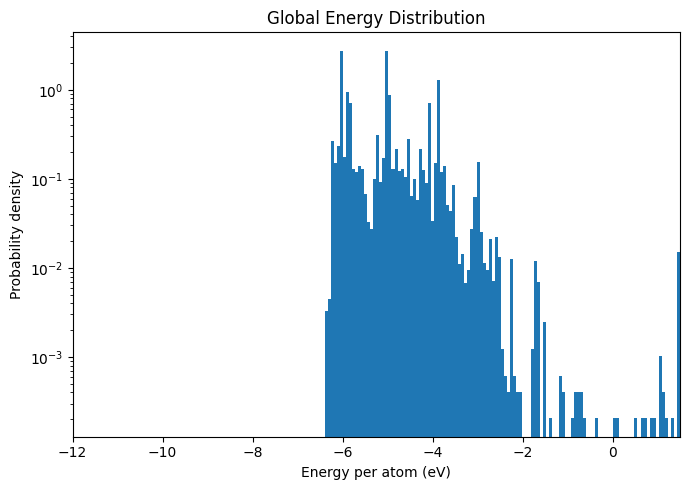

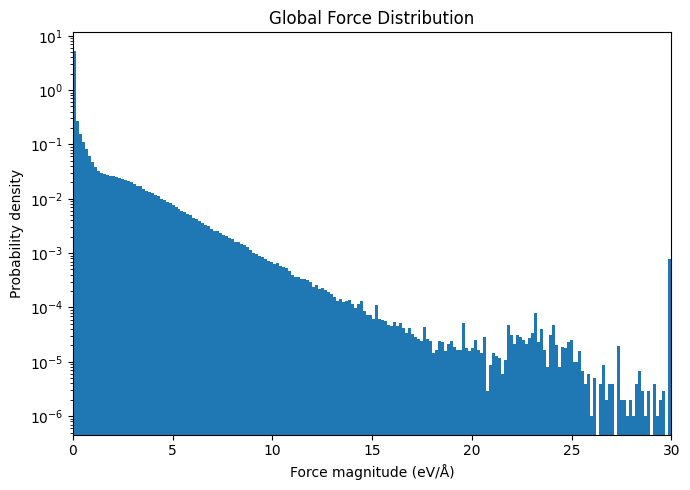

In [5]:
##GLOBAL HISTOGRAMS

E = np.array(global_energies)
F = np.array(global_forces)

def print_stats(label, data):
    print(f"\n=== {label} ===")
    print(f"count  : {len(data)}")
    print(f"mean   : {np.mean(data):.6f}")
    print(f"std    : {np.std(data):.6f}")
    print(f"min    : {np.min(data):.6f}")
    print(f"max    : {np.max(data):.6f}")
    print(f"median : {np.median(data):.6f}")

print_stats("GLOBAL ENERGY (per atom)", E)
print_stats("GLOBAL FORCE (per atom)", F)

# ---------------- Energy histogram ----------------
plt.figure(figsize=(7,5))
plt.hist(E, bins=ENERGY_BINS,
         range=(ENERGY_MIN, ENERGY_MAX),
         density=True)
plt.xlabel("Energy per atom (eV)")
plt.ylabel("Probability density")
plt.title("Global Energy Distribution")
plt.xlim(ENERGY_MIN, ENERGY_MAX)
if LOG_Y_ENERGY:
    plt.yscale("log")
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("global_energy_hist.png", dpi=FIG_DPI)
plt.show()

# ---------------- Force histogram ----------------
plt.figure(figsize=(7,5))
plt.hist(F, bins=FORCE_BINS,
         range=(FORCE_MIN, FORCE_MAX),
         density=True)
plt.xlabel("Force magnitude (eV/Å)")
plt.ylabel("Probability density")
plt.title("Global Force Distribution")
plt.xlim(FORCE_MIN, FORCE_MAX)
if LOG_Y_FORCE:
    plt.yscale("log")
plt.tight_layout()
if SAVE_FIGURES:
    plt.savefig("global_force_hist.png", dpi=FIG_DPI)
plt.show()


In [6]:
## per file histograms


=== aimd.xyz — ENERGY ===
count  : 8708
mean   : -5.195461
std    : 0.680695
min    : -6.365401
max    : -3.404034
median : -5.195426

=== aimd.xyz — FORCE ===
count  : 764208
mean   : 1.699151
std    : 1.954341
min    : 0.000006
max    : 24.294454
median : 0.832842


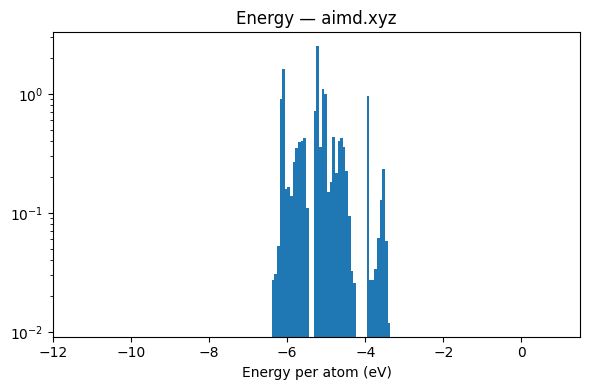

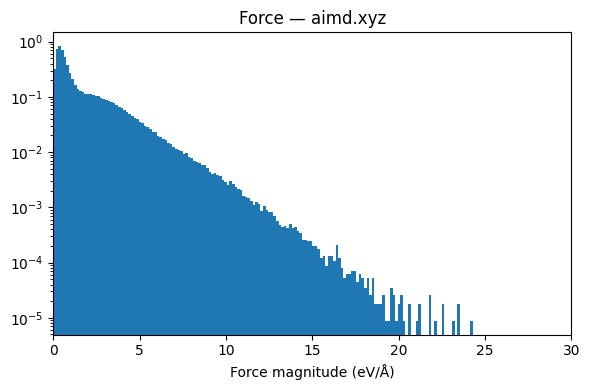


=== alloy.xyz — ENERGY ===
count  : 6394
mean   : -4.327914
std    : 1.226255
min    : -6.284776
max    : -1.179957
median : -4.243791

=== alloy.xyz — FORCE ===
count  : 321479
mean   : 0.158814
std    : 0.552387
min    : 0.000000
max    : 30.000000
median : 0.026137


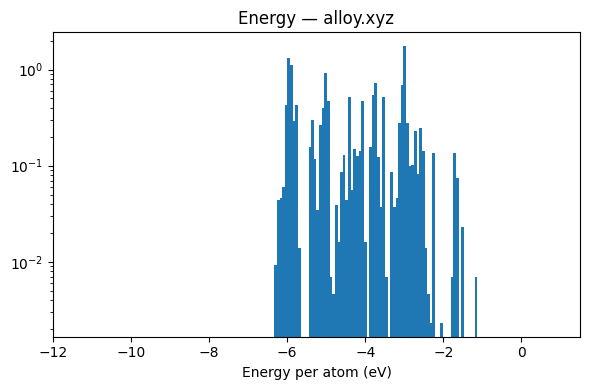

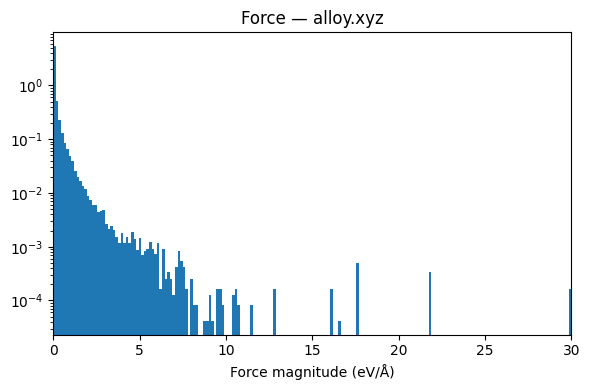


=== elastic_tensor.xyz — ENERGY ===
count  : 41481
mean   : -5.070913
std    : 0.778620
min    : -6.210993
max    : -3.811798
median : -5.002901

=== elastic_tensor.xyz — FORCE ===
count  : 4323531
mean   : 0.034971
std    : 0.141511
min    : 0.000000
max    : 25.627771
median : 0.009734


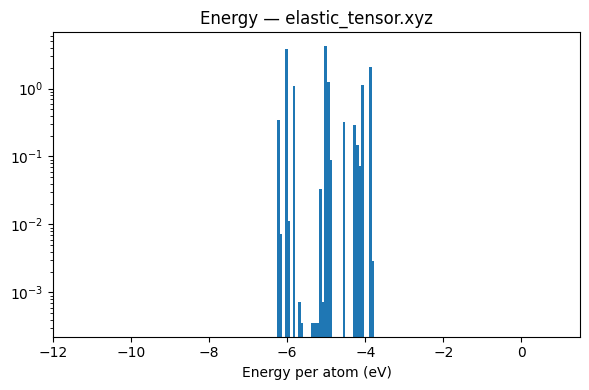

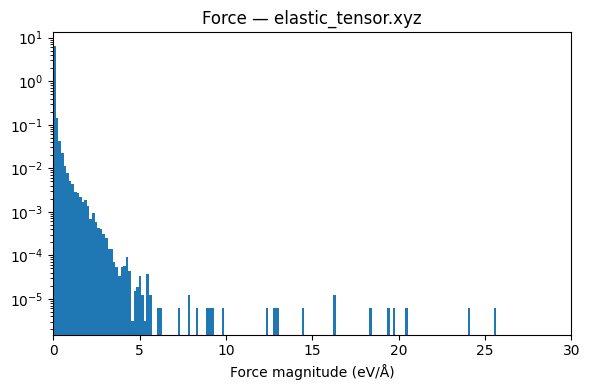


=== hetero.xyz — ENERGY ===
count  : 6906
mean   : -5.927636
std    : 0.075256
min    : -6.053687
max    : -5.239319
median : -5.883339

=== hetero.xyz — FORCE ===
count  : 966216
mean   : 0.139897
std    : 0.640555
min    : 0.000015
max    : 30.000000
median : 0.025521


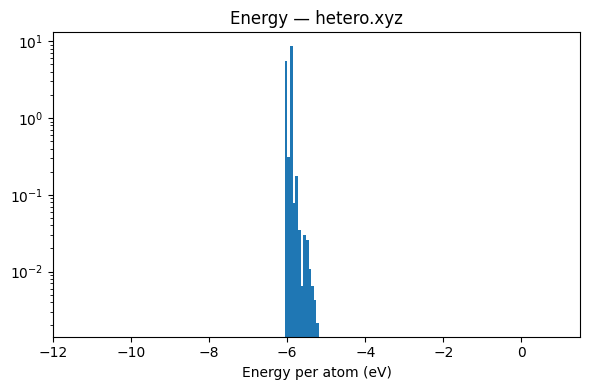

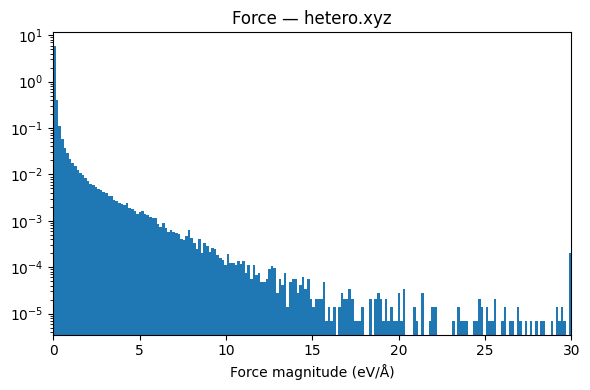


=== interface_gasp.xyz — ENERGY ===
count  : 152
mean   : -5.571326
std    : 0.296803
min    : -6.078594
max    : -4.281309
median : -5.500482

=== interface_gasp.xyz — FORCE ===
count  : 8487
mean   : 2.471668
std    : 5.370263
min    : 0.000055
max    : 28.814062
median : 0.285379


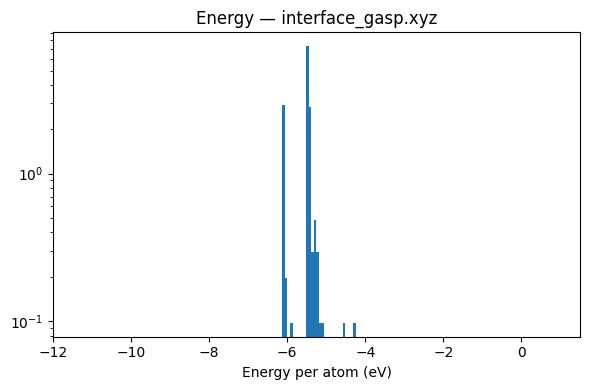

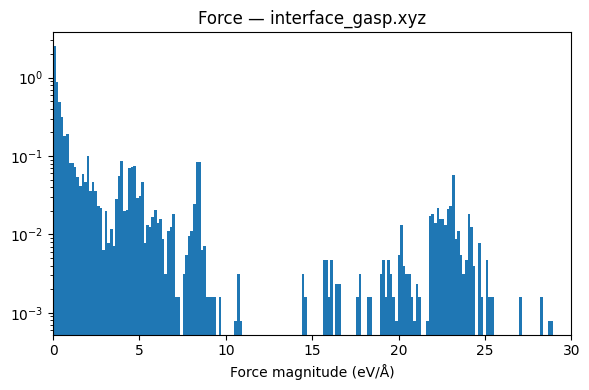


=== mos2.xyz — ENERGY ===
count  : 2681
mean   : -4.446980
std    : 0.479176
min    : -5.262394
max    : -3.105602
median : -4.699149

=== mos2.xyz — FORCE ===
count  : 200271
mean   : 2.857375
std    : 2.461433
min    : 0.000001
max    : 30.000000
median : 2.321510


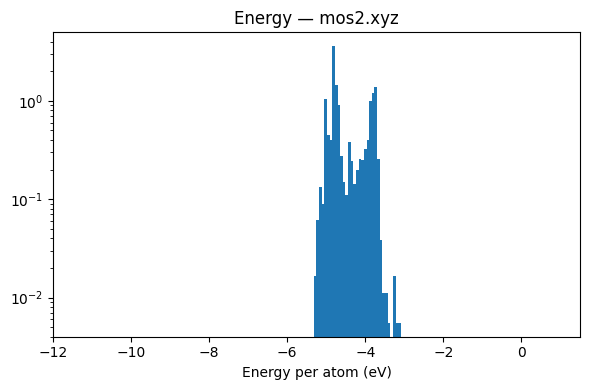

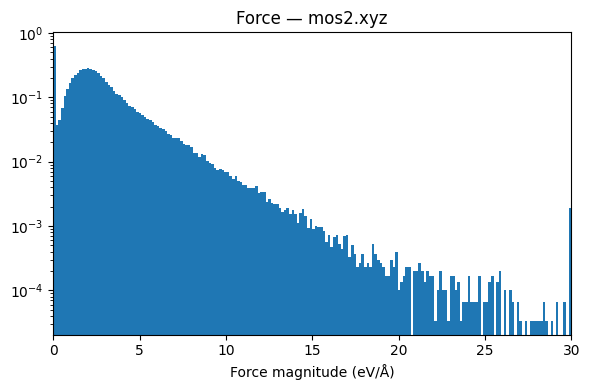


=== pressure.xyz — ENERGY ===
count  : 4168
mean   : -4.366654
std    : 1.144646
min    : -6.229041
max    : 1.500000
median : -4.488545

=== pressure.xyz — FORCE ===
count  : 70158
mean   : 1.118176
std    : 3.580673
min    : 0.000000
max    : 30.000000
median : 0.052669


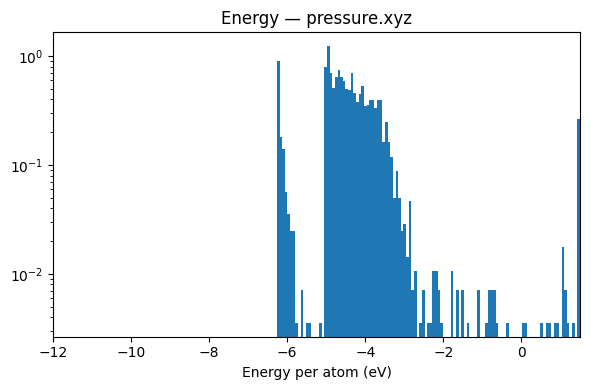

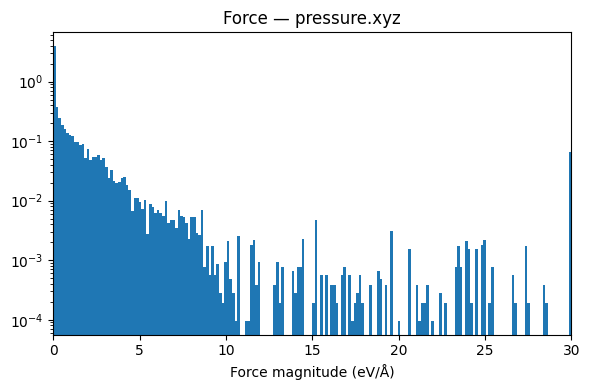


=== saph.xyz — ENERGY ===
count  : 1810
mean   : -5.681485
std    : 0.189245
min    : -6.210958
max    : -5.401788
median : -5.632483

=== saph.xyz — FORCE ===
count  : 94050
mean   : 3.107998
std    : 2.626013
min    : 0.000001
max    : 25.241164
median : 2.951579


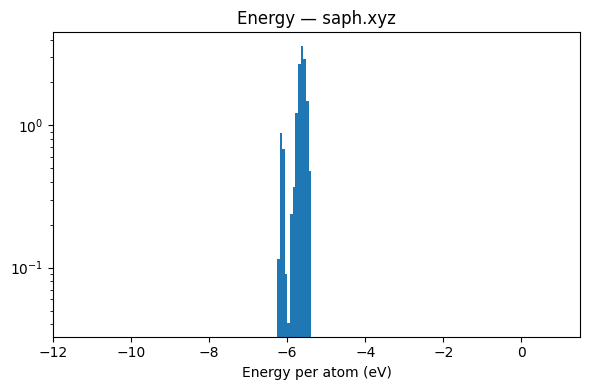

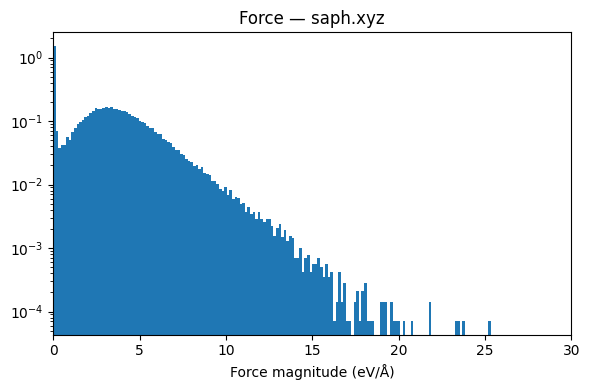

In [7]:
for fname, data in per_file.items():
    if len(data["E"]) == 0:
        continue

    print_stats(f"{fname} — ENERGY", np.array(data["E"]))
    print_stats(f"{fname} — FORCE",  np.array(data["F"]))

    # Energy
    plt.figure(figsize=(6,4))
    plt.hist(data["E"], bins=ENERGY_BINS,
             range=(ENERGY_MIN, ENERGY_MAX),
             density=True)
    plt.xlabel("Energy per atom (eV)")
    plt.title(f"Energy — {fname}")
    plt.xlim(ENERGY_MIN, ENERGY_MAX)
    if LOG_Y_ENERGY:
        plt.yscale("log")
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(f"energy_{fname}.png", dpi=FIG_DPI)
    plt.show()

    # Force
    plt.figure(figsize=(6,4))
    plt.hist(data["F"], bins=FORCE_BINS,
             range=(FORCE_MIN, FORCE_MAX),
             density=True)
    plt.xlabel("Force magnitude (eV/Å)")
    plt.title(f"Force — {fname}")
    plt.xlim(FORCE_MIN, FORCE_MAX)
    if LOG_Y_FORCE:
        plt.yscale("log")
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(f"force_{fname}.png", dpi=FIG_DPI)
    plt.show()
